This is an analysis of the TP53 screen, including presence and activity-based selection methods using ABE8e (RDA867) and TadCBEd (RDB270). All of the data analyzed includes read counts from self-edited guides. We restrict this data to NGN PAMs for this analysis.

In [6]:
#importing packages
import pandas as pd
from poola import core as pool
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gpplot as gpp
from itertools import product
import matplotlib.patches as patches

gpp.set_aesthetics()


from sklearn.metrics import auc, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

In [7]:
def get_guide_distributions(annotated_df, cell_line_avg_lfc, gene):
    sns.distplot(lfc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor')].loc[:,cell_line_avg_lfc],hist=False,label='Essential splice site control') #blue
    sns.distplot(lfc[lfc['Gene Symbol Bin'].str.contains('TP53')].loc[:,cell_line_avg_lfc],hist=False,label=gene) #orange
    sns.distplot(lfc[lfc['Gene Symbol Bin'].str.contains('NO_SITE')].loc[:,cell_line_avg_lfc],hist=False,label='Non-targeting control') #green
    sns.distplot(lfc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE')].loc[:,cell_line_avg_lfc],hist=False,label='Intergenic control') #red
    plt.title('TP53')
    plt.legend()
    #plt.show()
    plt.savefig
    
#code that calculates z-score of a given column of LFCs
def get_z_score(data,col,control_category):
    mean = data.loc[data['Target Gene ID'].str.contains(control_category),col].mean()
    std = data.loc[data['Target Gene ID'].str.contains(control_category),col].std()
    data[str(col + ';z-score')] = data[col].apply(lambda x: (x-mean)/std)
    print(mean)
    print(std)
    return data

In [8]:
#Fxn that gets amino acid residues to be plotted 
def GetResidues(string):
    new_string = ''
    if type(string) != float:
        edits = string.split(',')
        #split on comma for libraries designed with BEAGLE, split on semi-colon for libraries designed with Mudra's code
        for edit in edits:
            if edit.startswith('Exon'):
                new_string += 'intron;'
            elif edit == 'utr':
                new_string += 'utr;'
            elif edit == '':
                continue
            else:
                # Strip off all non-digit characters
                for character in edit:
                    if character.isdigit():        
                        new_string += character
                new_string += ';'
    return new_string

def GetMedianResidues(string):
    residues = string.split(';')
    if ('intron' in residues) or ('utr' in residues):
        return np.nan
    residues = [int(res) for res in residues if res != '']
    if len(residues) != 0:
        return np.median(residues)
    else:
        return np.nan

In [9]:
#this code consolidates annotations for targeting guides and controls
def GetMostSevereMutationType(string1, string2):
    if 'Nonsense' in string1:
        return 'Nonsense'
    elif 'Splice' in string1:
        return 'Splice site'
    elif 'Missense' in string1:
        return 'Missense'
    elif 'Intron' in string1:
        return 'Intron'        
    elif 'Silent' in string1:
        return 'Silent'
    elif 'UTR' in string1:
        return 'UTR'
    elif string1 == 'None':
        if 'NO_SITE' in string2:
            return 'Non-targeting control'
        elif 'ONE_NON-GENE_SITE' in string2:
            return 'Intergenic control'
        elif 'Panlethal splice donor' in string2:
            return 'Panlethal control'
        else:
            return 'No edits'

# ABE presence-based selection

In [10]:
annotation = pd.read_csv("../../required_data/TP53/TP53_tiling_NNNN_BE_annotations_5col.csv")

In [11]:
#reading in metainfo
meta_info = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN.txt', delimiter = "\t")
#NGN PAMs only
meta_info = meta_info[meta_info['PAM Sequence'].str[1]=='G']

#dropping extraneous columns and C>T annotations
meta_info.drop(meta_info[meta_info['Edit Type'] == 'C-T'].index, inplace=True)

#dropping guides that were not included in final library
meta_info_merged = pd.merge(meta_info, annotation, on='sgRNA Target Sequence')

In [12]:
annotation_controls = annotation[annotation['Target Gene ID']!='ENSG00000141510']
annotation = pd.merge(meta_info_merged['sgRNA Target Sequence'], annotation, on='sgRNA Target Sequence', how='inner')
annotation = pd.concat([annotation, annotation_controls], sort=False)

In [13]:
#import read counts file from POOLQ with self-editing added
read_counts = pd.read_csv('../../required_data/TP53/counts_with_mismatches_ABE_presence.csv')

In [14]:
#adding in annotations
annot_read_counts = annotation.merge(read_counts, left_on= 'sgRNA Target Sequence', right_on='Construct Barcode', how='inner')

In [15]:
#abbreviating column names
annot_read_counts.rename(columns = {
       'A549_RDA867CP1845DropoutA21':"DO_RepA_D21",
       'A549_RDA867CP1845DropoutB21':"DO_RepB_D21",
       'A549_RDA867CP1845EtoposideA21':"Eto_RepA_D21",
       'A549_RDA867CP1845EtoposideB21':"Eto_RepB_D21",
       }, inplace= True)

In [16]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=annot_read_counts, columns=['CP1845', 
                                                                'DO_RepA_D21', 'DO_RepB_D21','Eto_RepA_D21','Eto_RepB_D21'
                                                               ])

filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP1845'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 3 columns due to low pDNA abundance


In [17]:
#calculating lfcs from pDNA
lfc = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='CP1845', 
                             target_cols=['DO_RepA_D21', 'DO_RepB_D21'])

lfc['DO_RepAB_D21'] = lfc[["DO_RepA_D21","DO_RepB_D21"]].mean(axis=1)

In [18]:
#calculating lfcs from Drop out
lfc_from_drop_out = pool.calculate_lfcs(filtered_lognorms, ref_map = {'Eto_RepA_D21': 'DO_RepA_D21', 'Eto_RepB_D21': 'DO_RepB_D21'})
lfc_from_drop_out['Eto_RepAB_D21'] = lfc_from_drop_out[["Eto_RepA_D21","Eto_RepB_D21"]].mean(axis=1)

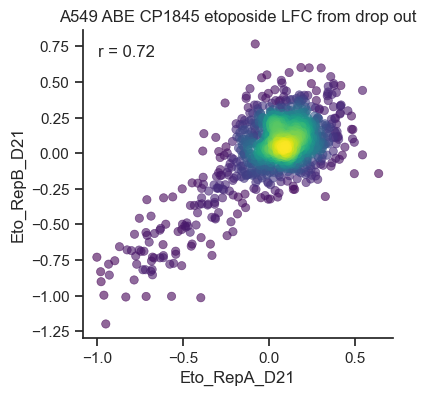

In [19]:
#### plotting dropout replicate correlations (lfc from drop out)
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
gpplot.add_correlation(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
plt.title('A549 ABE CP1845 etoposide LFC from drop out')
sns.despine()

Text(0.5, 1.05, 'ABE presence-based selection sgRNA distributions')

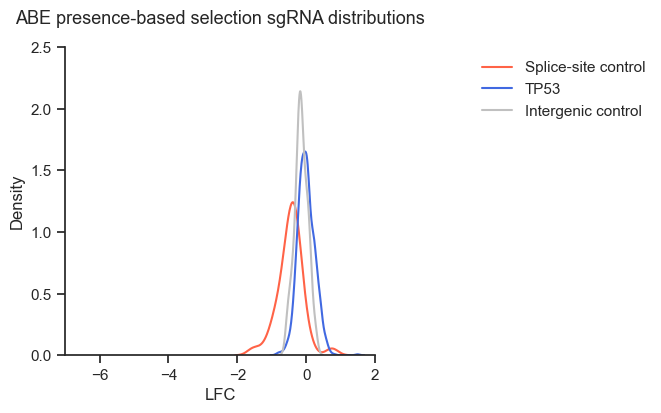

In [20]:
plt.subplots(figsize=(4,4))
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor'), 'DO_RepAB_D21'], label='Splice-site control', color='tomato')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('TP53'), 'DO_RepAB_D21'], label='TP53', color='royalblue')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE'), 'DO_RepAB_D21'], label='Intergenic control', color='silver')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), title='', frameon=False)

plt.ylabel('Density')
plt.ylim(0, 2.5)
plt.xlabel('LFC')
plt.xlim(-7, 2) 

plt.title('ABE presence-based selection sgRNA distributions', size=13, y=1.05)

### ROC-AUC

In [21]:
lfcv2=lfc[['DO_RepAB_D21', 'Gene Symbol Bin']]
lfcv2=lfcv2.dropna()
lfcv2['condition'] = 'DO_RepAB_D21'

In [22]:
roc_df = lfcv2
roc_df['pos_ctl'] = roc_df['Gene Symbol Bin'].isin(['Panlethal splice donor'])
roc_df['neg_ctl'] = roc_df['Gene Symbol Bin'].isin(['ONE_NON-GENE_SITE'])
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(roc_df['pos_ctl'], -roc_df['DO_RepAB_D21'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs_ABEpresence = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df_ABEpresence = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs_ABEpresence

,condition,ROC-AUC
0,DO_RepAB_D21,0.815244


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_48926/2134252242.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sgrna_tpr_fpr_df_ABEpresence, x='fpr',


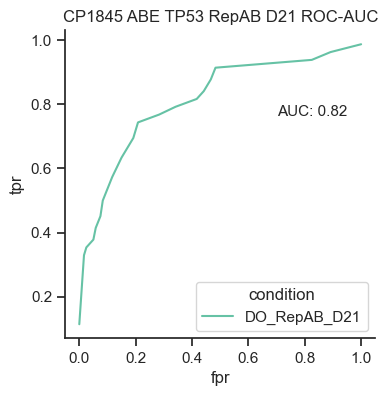

In [23]:
plt.subplots(figsize=(4, 4))
sns.lineplot(data=sgrna_tpr_fpr_df_ABEpresence, x='fpr',
             y='tpr', hue='condition', ci=None)
plt.title('CP1845 ABE TP53 RepAB D21 ROC-AUC')

plt.text(0.7, 0.8, 'AUC: 0.82', fontsize=11,
        verticalalignment='top')

sns.despine()

In [24]:
lfc_from_drop_out = get_z_score(lfc_from_drop_out,"Eto_RepAB_D21",'ONE_NON-GENE_SITE')

0.10087769602300065
0.09359779844755887


In [25]:
lfc = lfc_from_drop_out.merge(meta_info_merged[['Mutation Category','Amino Acid Edits','sgRNA Target Sequence']], on = 'sgRNA Target Sequence', how= 'outer')
lfc.dropna(subset=['Target Gene ID'], inplace=True)

In [26]:
unique_values = lfc['Mutation Category'].unique()

In [27]:
lfc['Mutation Category'] = lfc['Mutation Category'].fillna('None')
lfc['Mutation Category'].unique()

array(['Missense', 'Missense, Missense', 'None', 'Intron, Intron, Intron',
       'Silent', 'UTR, UTR, UTR, UTR', 'Intron, Intron',
       'Silent, Missense', 'UTR', 'Silent, Silent',
       'Missense, Splice-donor', 'Missense, Silent', 'Intron',
       'Intron, Intron, Intron, Intron', 'Splice-donor',
       'Intron, Missense', 'Silent, Silent, Missense',
       'Intron, Splice-acceptor', 'Silent, Splice-donor',
       'Silent, Missense, Missense', 'Splice-acceptor', 'Missense, UTR',
       'UTR, UTR', 'Splice-acceptor, Missense', 'UTR, UTR, UTR',
       'Splice-acceptor, Silent'], dtype=object)

In [28]:
lfc['Residues'] = lfc['Amino Acid Edits'].apply(GetResidues)
lfc['Median Residues'] = lfc['Residues'].apply(GetMedianResidues)

In [29]:
mutation_bin = []
for i,r in lfc.iterrows():
    mutation_bin.append(GetMostSevereMutationType(r['Mutation Category'], r['Gene Symbol Bin']))
lfc['Mutation bin'] = mutation_bin

In [30]:
zscore = lfc[['sgRNA Target Sequence','Target Gene Symbol','Eto_RepAB_D21;z-score','Median Residues','Mutation bin']].copy()
zscore['Drug arm']= "Etoposide"

In [31]:
zscore['mutation_type'] = np.where(zscore['Mutation bin'] == 'Missense', 'Missense', 
                                   np.where(zscore['Mutation bin'] == 'Silent', 'Silent',
                                            np.where(zscore['Mutation bin'] == 'Nonsense', 'Nonsense', '')))

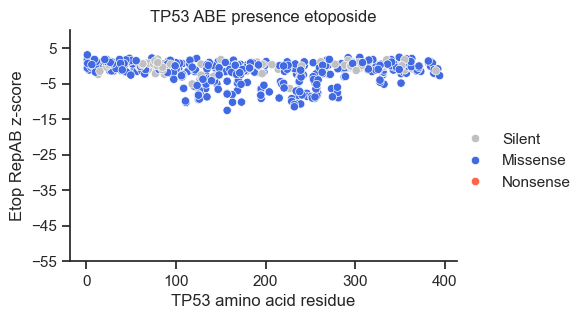

In [32]:
colors = {'Missense':'royalblue', 'Nonsense':'tomato', 'Silent': 'silver'}
fig, ax = plt.subplots(figsize=(5, 3))
a = sns.scatterplot(data=zscore, x="Median Residues", y="Eto_RepAB_D21;z-score", hue='mutation_type', palette=colors, hue_order=['Silent', 'Missense','Nonsense'])
a.set_ylabel('Etop RepAB z-score')
a.set_xlabel('TP53 amino acid residue')
a.set_ylim([-45, 10])
plt.yticks([-55,-45,-35,-25,-15,-5,5])
a.set_title('TP53 ABE presence etoposide', size=12)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(1.15, 0.25), ncol=1, title=None, frameon=False,fontsize=11)

sns.despine()

# ABE activity-based selection

In [33]:
annotation = pd.read_csv("../../required_data/TP53/TP53_tiling_NNNN_BE_annotations_5col.csv")

In [34]:
#reading in metainfo
meta_info = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN.txt', delimiter = "\t")
meta_info = meta_info[meta_info['PAM Sequence'].str[1]=='G']

#dropping extraneous columns and C>T annotations
meta_info.drop(meta_info[meta_info['Edit Type'] == 'C-T'].index, inplace=True)

#dropping guides that were not included in final library
meta_info_merged = pd.merge(meta_info, annotation, on='sgRNA Target Sequence')

In [35]:
annotation_controls = annotation[annotation['Target Gene ID']!='ENSG00000141510']
annotation = pd.merge(meta_info_merged['sgRNA Target Sequence'], annotation, on='sgRNA Target Sequence', how='inner')
annotation = pd.concat([annotation, annotation_controls], sort=False)

In [36]:
#import read counts file from POOLQ with self-editing added
read_counts = pd.read_csv('../../required_data/TP53/counts_with_mismatches_ABE_activity.csv')

In [37]:
#adding in annotations
annot_read_counts = annotation.merge(read_counts, left_on= 'sgRNA Target Sequence', right_on = 'Construct Barcode')

In [38]:
#abbreviating column names
annot_read_counts.rename(columns = {
       'A549_RDA867CP2087DropoutA21':"DO_RepA_D21",
       'A549_RDA867CP2088DropoutA21':"DO_RepB_D21",
       'A549_RDA867CP2087EtoposideA21':"Eto_RepA_D21",
       'A549_RDA867CP2088EtoposideA21':"Eto_RepB_D21",
       }, inplace= True)

In [39]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=annot_read_counts, columns=['CP2087', 'CP2088',
                                                                'DO_RepA_D21', 'DO_RepB_D21','Eto_RepA_D21','Eto_RepB_D21'
                                                               ])

filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP2087'], z_low=-3)
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP2088'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 3 columns due to low pDNA abundance


In [40]:
#calculating lfcs from pDNA
lfc = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_map = {'DO_RepA_D21': 'CP2087', 'DO_RepB_D21': 'CP2088'})

In [41]:
lfc['DO_RepAB_D21'] = lfc[["DO_RepA_D21","DO_RepB_D21"]].mean(axis=1)
lfc[lfc['Gene Symbol Bin']=='ONE_NON-GENE_SITE']['DO_RepAB_D21'].mean()

np.float64(-0.24043489419427017)

In [42]:
#calculating lfcs from Drop out
lfc_from_drop_out = pool.calculate_lfcs(filtered_lognorms, ref_map = {'Eto_RepA_D21': 'DO_RepA_D21', 'Eto_RepB_D21': 'DO_RepB_D21'})
lfc_from_drop_out['Eto_RepAB_D21'] = lfc_from_drop_out[["Eto_RepA_D21","Eto_RepB_D21"]].mean(axis=1)

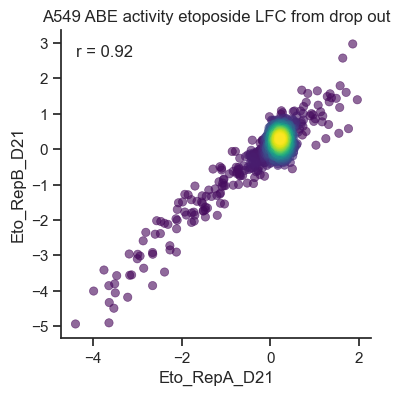

In [43]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
gpplot.add_correlation(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
plt.title('A549 ABE activity etoposide LFC from drop out')
sns.despine()

Text(0.5, 1.05, 'ABE activity-based selection sgRNA distributions')

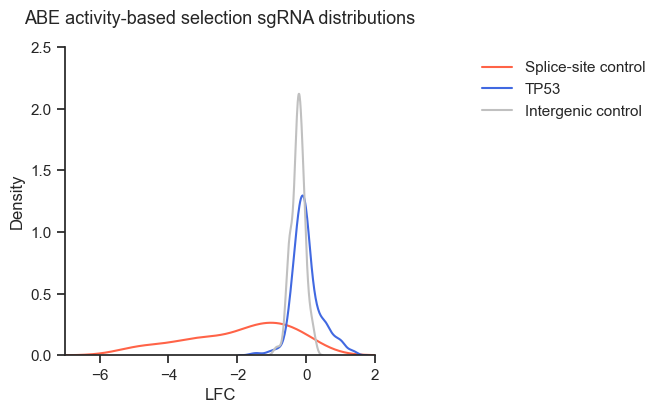

In [44]:
#get_guide_distributions(lfc,'DO_RepAB_D21', 'TP53')

plt.subplots(figsize=(4,4))
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor'), 'DO_RepAB_D21'], label='Splice-site control', color='tomato')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('TP53'), 'DO_RepAB_D21'], label='TP53', color='royalblue')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE'), 'DO_RepAB_D21'], label='Intergenic control', color='silver')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), title='', frameon=False)

plt.ylabel('Density')
plt.ylim(0, 2.5)
plt.xlabel('LFC')
plt.xlim(-7, 2) 

plt.title('ABE activity-based selection sgRNA distributions', size=13, y=1.05)

### ROC-AUC

In [45]:
lfcv2=lfc[['DO_RepAB_D21', 'Gene Symbol Bin']]
lfcv2=lfcv2.dropna()
lfcv2['condition'] = 'DO_RepAB_D21'

In [46]:
roc_df = lfcv2
roc_df['pos_ctl'] = roc_df['Gene Symbol Bin'].isin(['Panlethal splice donor'])
roc_df['neg_ctl'] = roc_df['Gene Symbol Bin'].isin(['ONE_NON-GENE_SITE'])
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(roc_df['pos_ctl'], -roc_df['DO_RepAB_D21'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs_ABEactivity = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df_ABEactivity = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs_ABEactivity

,condition,ROC-AUC
0,DO_RepAB_D21,0.880081


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_48926/2194981038.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sgrna_tpr_fpr_df_ABEactivity, x='fpr',


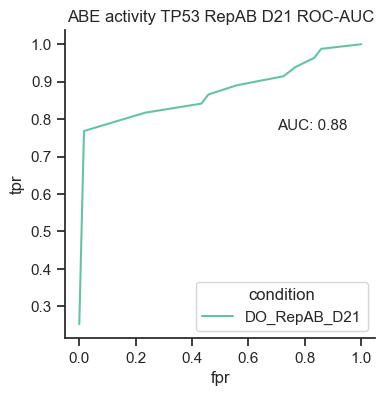

In [47]:
plt.subplots(figsize=(4, 4))
sns.lineplot(data=sgrna_tpr_fpr_df_ABEactivity, x='fpr',
             y='tpr', hue='condition', ci=None)
plt.title('ABE activity TP53 RepAB D21 ROC-AUC')

plt.text(0.7, 0.8, 'AUC: 0.88', fontsize=11,
        verticalalignment='top')

sns.despine()

In [48]:
lfc_from_drop_out = get_z_score(lfc_from_drop_out,"Eto_RepAB_D21",'ONE_NON-GENE_SITE')

0.2660492089311667
0.13508394802701634


In [49]:
lfc = lfc_from_drop_out.merge(meta_info_merged[['Mutation Category','Amino Acid Edits','sgRNA Target Sequence']], on = 'sgRNA Target Sequence', how= 'outer')
lfc.dropna(subset=['Target Gene ID'], inplace=True)

unique_values = lfc['Mutation Category'].unique()

lfc['Mutation Category'] = lfc['Mutation Category'].fillna('None')
lfc['Mutation Category'].unique()

lfc['Residues'] = lfc['Amino Acid Edits'].apply(GetResidues)
lfc['Median Residues'] = lfc['Residues'].apply(GetMedianResidues)

mutation_bin = []
for i,r in lfc.iterrows():
    mutation_bin.append(GetMostSevereMutationType(r['Mutation Category'], r['Gene Symbol Bin']))
lfc['Mutation bin'] = mutation_bin

zscore = lfc[['sgRNA Target Sequence','Target Gene Symbol','Eto_RepAB_D21;z-score','Median Residues','Mutation bin']].copy()
zscore['Drug arm']= "Etoposide"

In [50]:
zscore['mutation_type'] = np.where(zscore['Mutation bin'] == 'Missense', 'Missense', 
                                   np.where(zscore['Mutation bin'] == 'Silent', 'Silent',
                                            np.where(zscore['Mutation bin'] == 'Nonsense', 'Nonsense', '')))

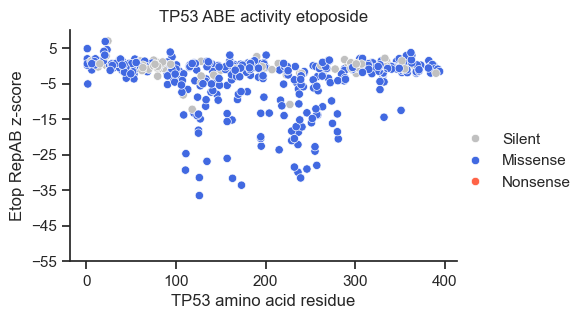

In [51]:
colors = {'Missense':'royalblue', 'Nonsense':'tomato', 'Silent': 'silver'}
fig, ax = plt.subplots(figsize=(5, 3))
a = sns.scatterplot(data=zscore, x="Median Residues", y="Eto_RepAB_D21;z-score", hue='mutation_type', palette=colors, hue_order=['Silent', 'Missense','Nonsense'])
a.set_ylabel('Etop RepAB z-score')
a.set_xlabel('TP53 amino acid residue')
a.set_ylim([-45, 10])
plt.yticks([-55,-45,-35,-25,-15,-5,5])
a.set_title('TP53 ABE activity etoposide', size=12)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(1.15, 0.25), ncol=1, title=None, frameon=False,fontsize=11)

sns.despine()

# CBE presence-based selection

In [52]:
annotation = pd.read_csv("../../required_data/TP53/TP53_tiling_NNNN_BE_annotations_5col.csv")

#reading in metainfo
meta_info = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN.txt', delimiter = "\t")
meta_info = meta_info[meta_info['PAM Sequence'].str[1]=='G']

#dropping extraneous columns and C>T annotations
meta_info.drop(meta_info[meta_info['Edit Type'] == 'A-G'].index, inplace=True)

#dropping guides that were not included in final library
meta_info_merged = pd.merge(meta_info, annotation, on='sgRNA Target Sequence')

#import read counts file from POOLQ with self-editing added
read_counts = pd.read_csv('../../required_data/TP53/counts_with_mismatches_CBE_presence.csv')

In [53]:
annotation_controls = annotation[annotation['Target Gene ID']!='ENSG00000141510']
annotation = pd.merge(meta_info_merged['sgRNA Target Sequence'], annotation, on='sgRNA Target Sequence', how='inner')
annotation = pd.concat([annotation, annotation_controls], sort=False)

In [54]:
#adding in annotations
annot_read_counts = annotation.merge(read_counts, left_on= 'sgRNA Target Sequence', right_on = 'Construct Barcode')

#abbreviating column names
annot_read_counts.rename(columns = {
       'A549_RDB270CP1845DropoutA21':"DO_RepA_D21",
       'A549_RDB270CP1845DropoutB21':"DO_RepB_D21",
       'A549_RDB270CP1845EtoposideA21':"Eto_RepA_D21",
       'A549_RDB270CP1845EtoposideB21':"Eto_RepB_D21",
       }, inplace= True)

In [55]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=annot_read_counts, columns=['CP1845', 
                                                                'DO_RepA_D21', 'DO_RepB_D21','Eto_RepA_D21','Eto_RepB_D21'
                                                               ])

filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP1845'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 3 columns due to low pDNA abundance


In [56]:
#calculating lfcs from pDNA
lfc = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='CP1845', 
                             target_cols=['DO_RepA_D21', 'DO_RepB_D21'])

lfc['DO_RepAB_D21'] = lfc[["DO_RepA_D21","DO_RepB_D21"]].mean(axis=1)

In [57]:
#calculating lfcs from Drop out
lfc_from_drop_out = pool.calculate_lfcs(filtered_lognorms, ref_map = {'Eto_RepA_D21': 'DO_RepA_D21', 'Eto_RepB_D21': 'DO_RepB_D21'})
lfc_from_drop_out['Eto_RepAB_D21'] = lfc_from_drop_out[["Eto_RepA_D21","Eto_RepB_D21"]].mean(axis=1)

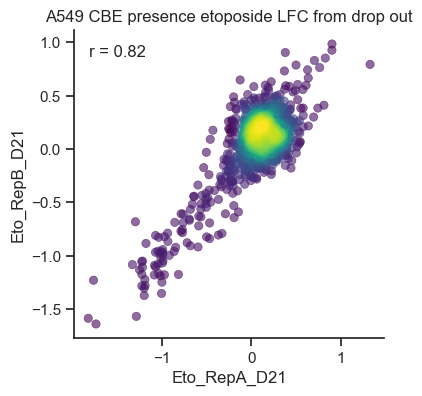

In [58]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
gpplot.add_correlation(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
plt.title('A549 CBE presence etoposide LFC from drop out')
sns.despine()

Text(0.5, 1.05, 'CBE presence-based selection sgRNA distributions')

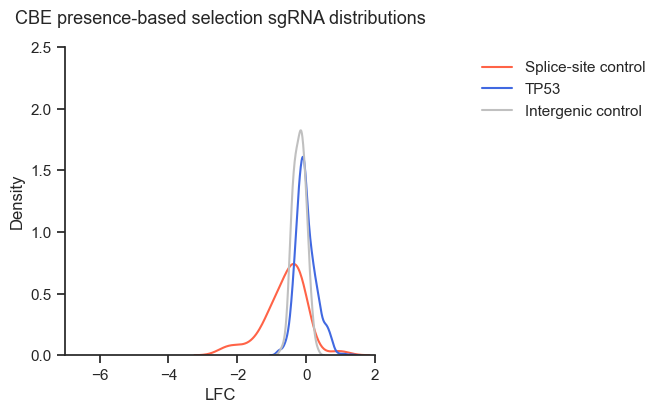

In [59]:
#get_guide_distributions(lfc,'DO_RepAB_D21', 'TP53')
plt.subplots(figsize=(4,4))
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor'), 'DO_RepAB_D21'], label='Splice-site control', color='tomato')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('TP53'), 'DO_RepAB_D21'], label='TP53', color='royalblue')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE'), 'DO_RepAB_D21'], label='Intergenic control', color='silver')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), title='', frameon=False)

plt.ylabel('Density')
plt.ylim(0, 2.5)
plt.xlabel('LFC')
plt.xlim(-7, 2) 

plt.title('CBE presence-based selection sgRNA distributions', size=13, y=1.05)

### ROC-AUC

In [60]:
lfcv2=lfc[['DO_RepAB_D21', 'Gene Symbol Bin']]
lfcv2=lfcv2.dropna()
lfcv2['condition'] = 'DO_RepAB_D21'

In [61]:
roc_df = lfcv2
roc_df['pos_ctl'] = roc_df['Gene Symbol Bin'].isin(['Panlethal splice donor'])
roc_df['neg_ctl'] = roc_df['Gene Symbol Bin'].isin(['ONE_NON-GENE_SITE'])
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(roc_df['pos_ctl'], -roc_df['DO_RepAB_D21'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs_CBEpresence = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df_CBEpresence = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs_CBEpresence

,condition,ROC-AUC
0,DO_RepAB_D21,0.764431


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_48926/2849418967.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sgrna_tpr_fpr_df_CBEpresence, x='fpr',


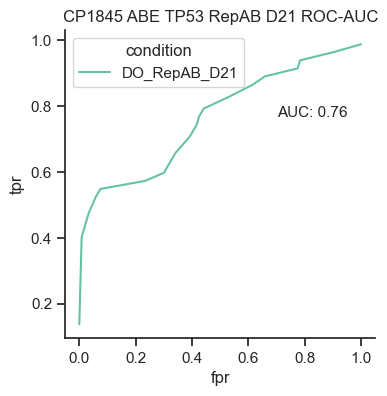

In [62]:
plt.subplots(figsize=(4, 4))
sns.lineplot(data=sgrna_tpr_fpr_df_CBEpresence, x='fpr',
             y='tpr', hue='condition', ci=None)
plt.title('CP1845 ABE TP53 RepAB D21 ROC-AUC')

plt.text(0.7, 0.8, 'AUC: 0.76', fontsize=11,
        verticalalignment='top')

sns.despine()

In [63]:
lfc_from_drop_out = get_z_score(lfc_from_drop_out,"Eto_RepAB_D21",'ONE_NON-GENE_SITE')

0.1586439542900658
0.1073517587797049


In [64]:
lfc = lfc_from_drop_out.merge(meta_info_merged[['Mutation Category','Amino Acid Edits','sgRNA Target Sequence']], on = 'sgRNA Target Sequence', how= 'outer')
lfc.dropna(subset=['Target Gene ID'], inplace=True)

unique_values = lfc['Mutation Category'].unique()

lfc['Mutation Category'] = lfc['Mutation Category'].fillna('None')
lfc['Mutation Category'].unique()

lfc['Residues'] = lfc['Amino Acid Edits'].apply(GetResidues)
lfc['Median Residues'] = lfc['Residues'].apply(GetMedianResidues)

mutation_bin = []
for i,r in lfc.iterrows():
    mutation_bin.append(GetMostSevereMutationType(r['Mutation Category'], r['Gene Symbol Bin']))
lfc['Mutation bin'] = mutation_bin

zscore = lfc[['sgRNA Target Sequence','Target Gene Symbol','Eto_RepAB_D21;z-score','Median Residues','Mutation bin']].copy()
zscore['Drug arm']= "Etoposide"

In [65]:
zscore['mutation_type'] = np.where(zscore['Mutation bin'] == 'Missense', 'Missense', 
                                   np.where(zscore['Mutation bin'] == 'Silent', 'Silent',
                                            np.where(zscore['Mutation bin'] == 'Nonsense', 'Nonsense', '')))

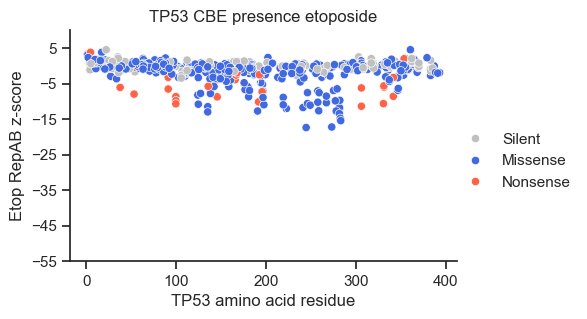

In [66]:
colors = {'Missense':'royalblue', 'Nonsense':'tomato', 'Silent': 'silver'}
fig, ax = plt.subplots(figsize=(5, 3))
a = sns.scatterplot(data=zscore, x="Median Residues", y="Eto_RepAB_D21;z-score", hue='mutation_type', palette=colors, hue_order=['Silent', 'Missense','Nonsense'])
a.set_ylabel('Etop RepAB z-score')
a.set_xlabel('TP53 amino acid residue')
a.set_ylim([-45, 10])
plt.yticks([-55,-45,-35,-25,-15,-5,5])
a.set_title('TP53 CBE presence etoposide', size=12)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(1.15, 0.25), ncol=1, title=None, frameon=False,fontsize=11)

sns.despine()

# CBE activity-based selection

In [67]:
annotation = pd.read_csv("../../required_data/TP53/TP53_tiling_NNNN_BE_annotations_5col.csv")

#reading in metainfo
meta_info = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN.txt', delimiter = "\t")
meta_info = meta_info[meta_info['PAM Sequence'].str[1]=='G']

#dropping extraneous columns and C>T annotations
meta_info.drop(meta_info[meta_info['Edit Type'] == 'A-G'].index, inplace=True)

#dropping guides that were not included in final library
meta_info_merged = pd.merge(meta_info, annotation, on='sgRNA Target Sequence')

#import read counts file from POOLQ with self-editing added
read_counts = pd.read_csv('../../required_data/TP53/counts_with_mismatches_CBE_activity.csv')

In [68]:
annotation_controls = annotation[annotation['Target Gene ID']!='ENSG00000141510']
annotation = pd.merge(meta_info_merged['sgRNA Target Sequence'], annotation, on='sgRNA Target Sequence', how='inner')
annotation = pd.concat([annotation, annotation_controls], sort=False)

In [69]:
#adding in annotations
annot_read_counts = annotation.merge(read_counts, left_on= 'sgRNA Target Sequence', right_on = 'Construct Barcode')

#abbreviating column names
annot_read_counts.rename(columns = {
       'A549_RDB270CP2089DropoutA21':"DO_RepA_D21",
       'A549_RDB270CP2090DropoutA21':"DO_RepB_D21",
       'A549_RDB270CP2089EtoposideA21':"Eto_RepA_D21",
       'A549_RDB270CP2090EtoposideA21':"Eto_RepB_D21",
       }, inplace= True)

In [70]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=annot_read_counts, columns=['CP2089', 'CP2090',
                                                                'DO_RepA_D21', 'DO_RepB_D21','Eto_RepA_D21','Eto_RepB_D21'
                                                               ])

filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP2089'], z_low=-3)
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP2090'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 5 columns due to low pDNA abundance


In [71]:
#calculating lfcs from pDNA
lfc = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_map = {'DO_RepA_D21': 'CP2089', 'DO_RepB_D21': 'CP2090'})

In [72]:
lfc['DO_RepAB_D21'] = lfc[["DO_RepA_D21","DO_RepB_D21"]].mean(axis=1)
lfc[lfc['Gene Symbol Bin']=='ONE_NON-GENE_SITE']['DO_RepAB_D21'].mean()

np.float64(-0.19313684639307324)

In [73]:
#calculating lfcs from Drop out
lfc_from_drop_out = pool.calculate_lfcs(filtered_lognorms, ref_map = {'Eto_RepA_D21': 'DO_RepA_D21', 'Eto_RepB_D21': 'DO_RepB_D21'})
lfc_from_drop_out['Eto_RepAB_D21'] = lfc_from_drop_out[["Eto_RepA_D21","Eto_RepB_D21"]].mean(axis=1)

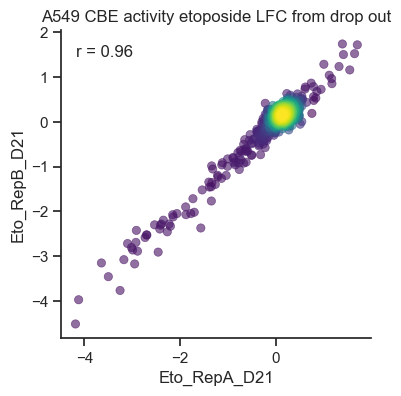

In [74]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
gpplot.add_correlation(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
plt.title('A549 CBE activity etoposide LFC from drop out')
sns.despine()

Text(0.5, 1.05, 'CBE activity-based selection sgRNA distributions')

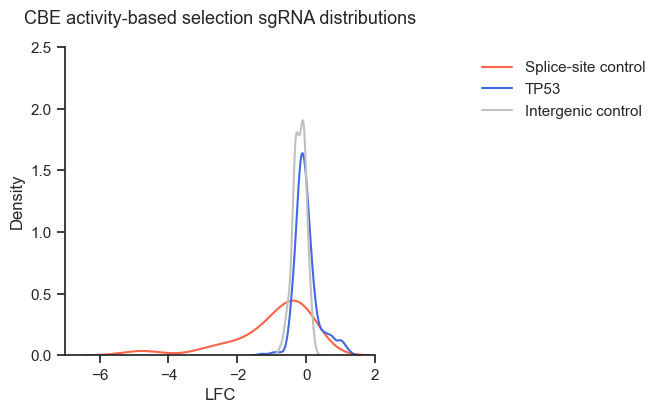

In [75]:
#get_guide_distributions(lfc,'DO_RepAB_D21', 'TP53')
plt.subplots(figsize=(4,4))
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor'), 'DO_RepAB_D21'], label='Splice-site control', color='tomato')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('TP53'), 'DO_RepAB_D21'], label='TP53', color='royalblue')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE'), 'DO_RepAB_D21'], label='Intergenic control', color='silver')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), title='', frameon=False)

plt.ylabel('Density')
plt.ylim(0, 2.5)
plt.xlabel('LFC')
plt.xlim(-7, 2) 

plt.title('CBE activity-based selection sgRNA distributions', size=13, y=1.05)

### ROC-AUC

In [76]:
lfcv2=lfc[['DO_RepAB_D21', 'Gene Symbol Bin']]
lfcv2=lfcv2.dropna()
lfcv2['condition'] = 'DO_RepAB_D21'

In [77]:
roc_df = lfcv2
roc_df['pos_ctl'] = roc_df['Gene Symbol Bin'].isin(['Panlethal splice donor'])
roc_df['neg_ctl'] = roc_df['Gene Symbol Bin'].isin(['ONE_NON-GENE_SITE'])
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(roc_df['pos_ctl'], -roc_df['DO_RepAB_D21'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs_CBEactivity = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df_CBEactivity = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs_CBEactivity

,condition,ROC-AUC
0,DO_RepAB_D21,0.74126


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_48926/2818728427.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sgrna_tpr_fpr_df_CBEactivity, x='fpr',


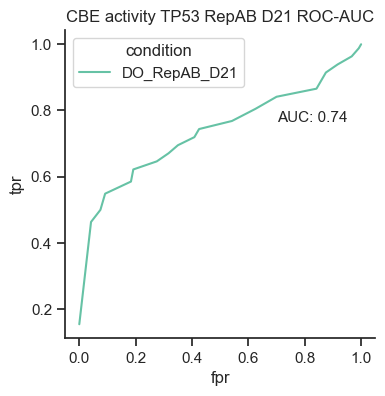

In [78]:
plt.subplots(figsize=(4, 4))
sns.lineplot(data=sgrna_tpr_fpr_df_CBEactivity, x='fpr',
             y='tpr', hue='condition', ci=None)
plt.title('CBE activity TP53 RepAB D21 ROC-AUC')

plt.text(0.7, 0.8, 'AUC: 0.74', fontsize=11,
        verticalalignment='top')

sns.despine()
#plt.savefig('../Figures/CBE_activity_repAB_ROC-AUC.png', dpi=300, bbox_inches='tight', transparent=True)

In [79]:
lfc_from_drop_out = get_z_score(lfc_from_drop_out,"Eto_RepAB_D21",'ONE_NON-GENE_SITE')

0.1876236650398077
0.0857359024865983


In [80]:
lfc = lfc_from_drop_out.merge(meta_info_merged[['Mutation Category','Amino Acid Edits','sgRNA Target Sequence']], on = 'sgRNA Target Sequence', how= 'outer')
lfc.dropna(subset=['Target Gene ID'], inplace=True)

unique_values = lfc['Mutation Category'].unique()

lfc['Mutation Category'] = lfc['Mutation Category'].fillna('None')
lfc['Mutation Category'].unique()

lfc['Residues'] = lfc['Amino Acid Edits'].apply(GetResidues)
lfc['Median Residues'] = lfc['Residues'].apply(GetMedianResidues)

mutation_bin = []
for i,r in lfc.iterrows():
    mutation_bin.append(GetMostSevereMutationType(r['Mutation Category'], r['Gene Symbol Bin']))
lfc['Mutation bin'] = mutation_bin

zscore = lfc[['sgRNA Target Sequence','Target Gene Symbol','Eto_RepAB_D21;z-score','Median Residues','Mutation bin']].copy()
zscore['Drug arm']= "Etoposide"

In [81]:
zscore['mutation_type'] = np.where(zscore['Mutation bin'] == 'Missense', 'Missense', 
                                   np.where(zscore['Mutation bin'] == 'Silent', 'Silent',
                                            np.where(zscore['Mutation bin'] == 'Nonsense', 'Nonsense', '')))

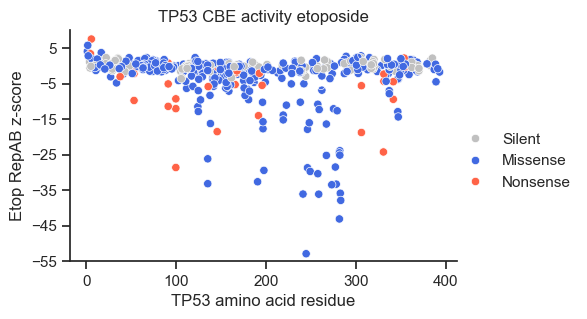

In [82]:
colors = {'Missense':'royalblue', 'Nonsense':'tomato', 'Silent': 'silver'}
fig, ax = plt.subplots(figsize=(5, 3))
a = sns.scatterplot(data=zscore, x="Median Residues", y="Eto_RepAB_D21;z-score", hue='mutation_type', palette=colors, hue_order=['Silent', 'Missense','Nonsense'])
a.set_ylabel('Etop RepAB z-score')
a.set_xlabel('TP53 amino acid residue')
a.set_ylim([-45, 10])
plt.yticks([-55,-45,-35,-25,-15,-5,5])
a.set_title('TP53 CBE activity etoposide', size=12)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(1.15, 0.25), ncol=1, title=None, frameon=False,fontsize=11)

sns.despine()

# Cas9-WT (nuclease)

In [83]:
annotation = pd.read_csv("../../required_data/TP53/TP53_tiling_NNNN_BE_annotations_5col.csv")

#reading in metainfo
meta_info = pd.read_csv('../../required_data/TP53/TP53_tiling_NNNN.txt', delimiter = "\t")
meta_info = meta_info[meta_info['PAM Sequence'].str[1]=='G']

#dropping guides that were not included in final library
meta_info_merged = pd.merge(meta_info, annotation, on='sgRNA Target Sequence')

#import read counts file from POOLQ with self-editing added
read_counts = pd.read_csv('../../required_data/TP53/counts_TP53_presence.txt', sep='\t')

In [84]:
annotation_controls = annotation[annotation['Target Gene ID']!='ENSG00000141510']
annotation = pd.merge(meta_info_merged['sgRNA Target Sequence'], annotation, on='sgRNA Target Sequence', how='inner')
annotation = pd.concat([annotation, annotation_controls], sort=False)

In [85]:
#adding in annotations
annot_read_counts = annotation.merge(read_counts, left_on= 'sgRNA Target Sequence', right_on = 'Construct Barcode')

#abbreviating column names
#Note 268 indicates that this is the condition using Cas9 nuclease
annot_read_counts.rename(columns = {
       'A549_RDB268CP1845DropoutA21':"DO_RepA_D21",
       'A549_RDB268CP1845DropoutB21':"DO_RepB_D21",
       'A549_RDB268CP1845EtoposideA21':"Eto_RepA_D21",
       'A549_RDB268CP1845EtoposideB21':"Eto_RepB_D21",
       }, inplace= True)

In [86]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=annot_read_counts, columns=['CP1845', 
                                                                'DO_RepA_D21', 'DO_RepB_D21','Eto_RepA_D21','Eto_RepB_D21'
                                                               ])

filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP1845'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 6 columns due to low pDNA abundance


In [87]:
#calculating lfcs from pDNA
lfc = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='CP1845', 
                             target_cols=['DO_RepA_D21', 'DO_RepB_D21'])

lfc['DO_RepAB_D21'] = lfc[["DO_RepA_D21","DO_RepB_D21"]].mean(axis=1)

In [88]:
#calculating lfcs from Drop out
lfc_from_drop_out = pool.calculate_lfcs(filtered_lognorms, ref_map = {'Eto_RepA_D21': 'DO_RepA_D21', 'Eto_RepB_D21': 'DO_RepB_D21'})
lfc_from_drop_out['Eto_RepAB_D21'] = lfc_from_drop_out[["Eto_RepA_D21","Eto_RepB_D21"]].mean(axis=1)

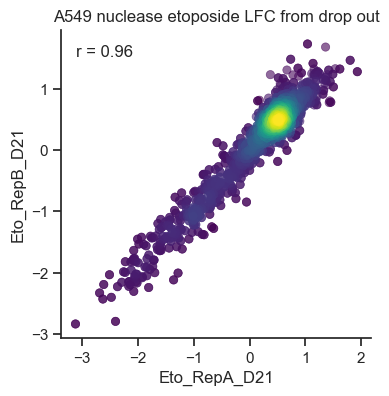

In [89]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
gpplot.add_correlation(data=lfc_from_drop_out, x='Eto_RepA_D21', y='Eto_RepB_D21')
plt.title('A549 nuclease etoposide LFC from drop out')
sns.despine()

Text(0.5, 1.05, 'Nuclease sgRNA distributions')

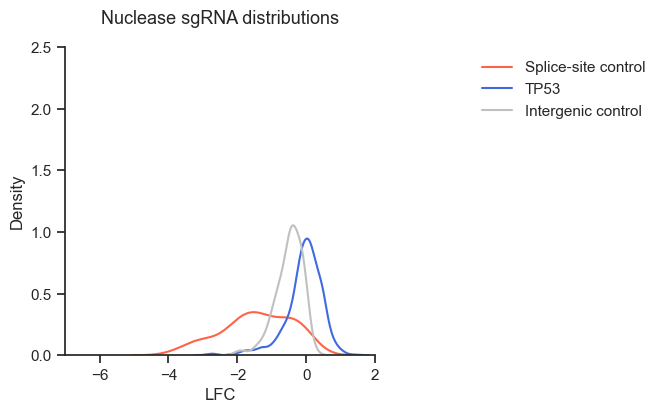

In [90]:
plt.subplots(figsize=(4,4))
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('Panlethal splice donor'), 'DO_RepAB_D21'], label='Splice-site control', color='tomato')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('TP53'), 'DO_RepAB_D21'], label='TP53', color='royalblue')
sns.kdeplot(lfc.loc[lfc['Gene Symbol Bin'].str.contains('ONE_NON-GENE_SITE'), 'DO_RepAB_D21'], label='Intergenic control', color='silver')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), title='', frameon=False)

plt.ylabel('Density')
plt.ylim(0, 2.5)
plt.xlabel('LFC')
plt.xlim(-7, 2) 

plt.title('Nuclease sgRNA distributions', size=13, y=1.05)

In [91]:
lfcv2=lfc[['DO_RepAB_D21', 'Gene Symbol Bin']]
lfcv2=lfcv2.dropna()
lfcv2['condition'] = 'DO_RepAB_D21'

In [92]:
roc_df = lfcv2
roc_df['pos_ctl'] = roc_df['Gene Symbol Bin'].isin(['Panlethal splice donor'])
roc_df['neg_ctl'] = roc_df['Gene Symbol Bin'].isin(['ONE_NON-GENE_SITE'])
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(roc_df['pos_ctl'], -roc_df['DO_RepAB_D21'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs_nuclease = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df_nuclease = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs_nuclease

,condition,ROC-AUC
0,DO_RepAB_D21,0.779065


In [93]:
lfc_from_drop_out = get_z_score(lfc_from_drop_out,"Eto_RepAB_D21",'ONE_NON-GENE_SITE')

0.6158530410170672
0.18443575825910075


In [94]:
lfc = lfc_from_drop_out.merge(meta_info_merged[['Mutation Category','Amino Acid Edits','sgRNA Target Sequence']], on = 'sgRNA Target Sequence', how= 'outer')
lfc.dropna(subset=['Target Gene ID'], inplace=True)

unique_values = lfc['Mutation Category'].unique()

lfc['Mutation Category'] = lfc['Mutation Category'].fillna('None')
lfc['Mutation Category'].unique()

lfc['Residues'] = lfc['Amino Acid Edits'].apply(GetResidues)
lfc['Median Residues'] = lfc['Residues'].apply(GetMedianResidues)

mutation_bin = []
for i,r in lfc.iterrows():
    mutation_bin.append(GetMostSevereMutationType(r['Mutation Category'], r['Gene Symbol Bin']))
lfc['Mutation bin'] = mutation_bin

zscore = lfc[['sgRNA Target Sequence','Target Gene Symbol','Eto_RepAB_D21;z-score','Median Residues','Mutation bin']].copy()
zscore['Drug arm']= "Etoposide"

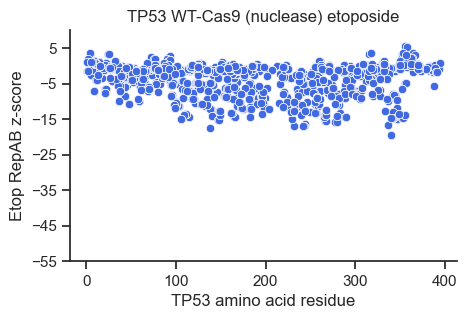

In [95]:
fig, ax = plt.subplots(figsize=(5, 3))
a = sns.scatterplot(data=zscore, x="Median Residues", y="Eto_RepAB_D21;z-score", color='royalblue')
a.set_ylabel('Etop RepAB z-score')
a.set_xlabel('TP53 amino acid residue')
a.set_ylim([-45, 10])
plt.yticks([-55,-45,-35,-25,-15,-5,5])
a.set_title('TP53 WT-Cas9 (nuclease) etoposide', size=12)
sns.despine()

In [96]:
zscore = zscore.drop_duplicates(subset=['sgRNA Target Sequence'], keep='first').reset_index(drop=True)